# Example 3: Pulse Parametrization

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

This example illustrates the parametrization of control pulses as a
form of amplitude constraint.

In [1]:
const PROJECTDIR = dirname(Base.active_project())
projectdir(names...) = joinpath(PROJECTDIR, names...)
datadir(names...) = projectdir("data", names...)

using QuantumControl
using QuantumControl.Shapes: flattop
using QuantumControl.Generators
using QuantumControl.Controls
using QuantumControl.PulseParametrizations:
    SquareParametrization,
    TanhParametrization,
    TanhSqParametrization,
    LogisticParametrization,
    LogisticSqParametrization,
    ParametrizedAmplitude
using LinearAlgebra

In [2]:
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :top,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8),
)

## Parametrizations

## Symmetric Bounded Controls

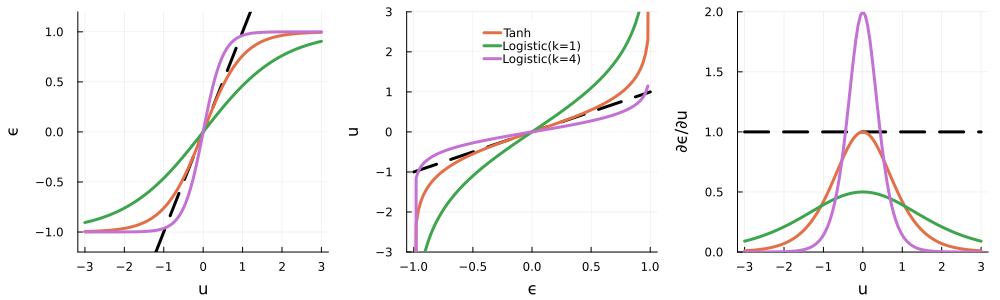

In [3]:
include(joinpath(@__DIR__, "plots", "symmetric_parametrization_comparison.jl"))  # hide
fig = plot_symmetric_parametrization_comparison()  # hide

## Positive (Bounded) Controls

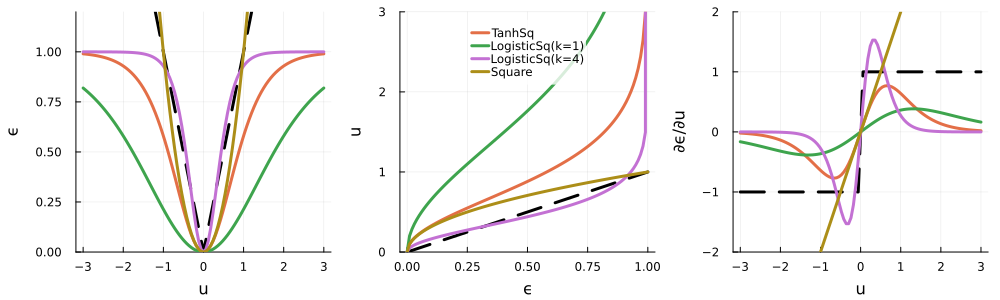

In [4]:
include(joinpath(@__DIR__, "plots", "positive_parametrization_comparison.jl"))  # hide
fig = plot_positive_parametrization_comparison()  # hide

## Two-level Hamiltonian

We consider the Hamiltonian $\op{H}_{0} = - \frac{\omega}{2} \op{\sigma}_{z}$, representing
a simple qubit with energy level splitting $\omega$ in the basis
$\{\ket{0},\ket{1}\}$. The control field $\epsilon(t)$ is assumed to couple via
the Hamiltonian $\op{H}_{1}(t) = \epsilon(t) \op{\sigma}_{x}$ to the qubit,
i.e., the control field effectively drives transitions between both qubit
states.

We we will use

In [5]:
ϵ(t) = 0.2 * flattop(t, T=5, t_rise=0.3, func=:blackman);

In [6]:
"""Two-level-system Hamiltonian."""
function tls_hamiltonian(; Ω=1.0, ampl=ϵ)
    σ̂_z = ComplexF64[
        1  0
        0 -1
    ]
    σ̂_x = ComplexF64[
        0  1
        1  0
    ]
    Ĥ₀ = -0.5 * Ω * σ̂_z
    Ĥ₁ = σ̂_x
    return hamiltonian(Ĥ₀, (Ĥ₁, ampl))
end;

In [7]:
H = tls_hamiltonian();

The control field here switches on from zero at $t=0$ to it's maximum amplitude
0.2 within the time period 0.3 (the switch-on shape is half a [Blackman pulse](https://en.wikipedia.org/wiki/Window_function#Blackman_window)).
It switches off again in the time period 0.3 before the
final time $T=5$). We use a time grid with 500 time steps between 0 and $T$:

In [8]:
tlist = collect(range(0, 5, length=500));

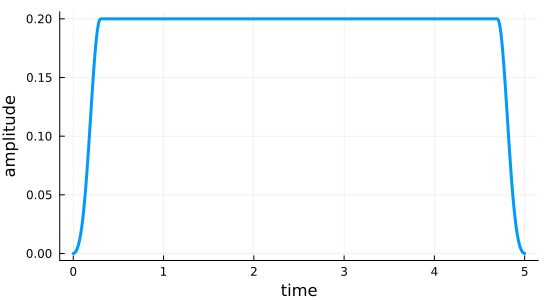

In [9]:
function plot_amplitude(ampl, tlist)
    plot(tlist, discretize(ampl, tlist), xlabel="time", ylabel="amplitude", legend=false)
end

plot_amplitude(ϵ, tlist)

## Optimization target

The `krotov` package requires the goal of the optimization to be described by a
list of `Objective` instances. In this example, there is only a single
objective: the state-to-state transfer from initial state $\ket{\Psi_{\init}} =
\ket{0}$ to the target state $\ket{\Psi_{\tgt}} = \ket{1}$, under the dynamics
of the Hamiltonian $\op{H}(t)$:

In [10]:
function ket(label)
    result = Dict("0" => Vector{ComplexF64}([1, 0]), "1" => Vector{ComplexF64}([0, 1]),)
    return result[string(label)]
end;

In [11]:
objectives = [Objective(initial_state=ket(0), generator=H, target_state=ket(1))]

1-element Vector{Objective{Vector{ComplexF64}, QuantumPropagators.Generators.Generator{Matrix{ComplexF64}, typeof(Main.var"##308".ϵ)}}}:
 Objective{Vector{ComplexF64}, QuantumPropagators.Generators.Generator{Matrix{ComplexF64}, typeof(Main.var"##308".ϵ)}}(…)

## Square-parametrization for positive pulses

In [12]:
a = ParametrizedAmplitude(
    ϵ,
    tlist;
    parametrization=SquareParametrization(),
    parameterize=true
)

ParametrizedAmplitude(::Vector{Float64}; parametrization=SquareParametrization())

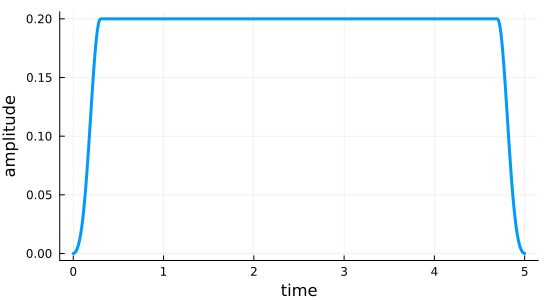

In [13]:
function plot_amplitude(ampl::ParametrizedAmplitude, tlist)
    plot(
        tlist,
        discretize(Array(ampl), tlist),
        xlabel="time",
        ylabel="amplitude",
        legend=false
    )
end

plot_amplitude(a, tlist)

In [14]:
problem = ControlProblem(
    objectives=substitute(objectives, IdDict(ϵ => a)),
    lambda_a=5,
    update_shape=(t -> flattop(t, T=5, t_rise=0.3, func=:blackman)),
    tlist=tlist,
    iter_stop=50,
    J_T=QuantumControl.Functionals.J_T_ss,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end
);

In [15]:
opt_result_positive = @optimize_or_load(
    datadir("parametrization#opt_result_positive.jld2"),
    problem;
    method=:krotov
);

In [16]:
opt_result_positive

Krotov Optimization Result
--------------------------
- Started at 2022-10-28T20:42:00.334
- Number of objectives: 1
- Number of iterations: 50
- Value of functional: 3.53585e-02
- Reason for termination: Reached maximum number of iterations
- Ended at 2022-10-28T20:42:04.552 (4 seconds, 218 milliseconds)


We can plot the optimized field:

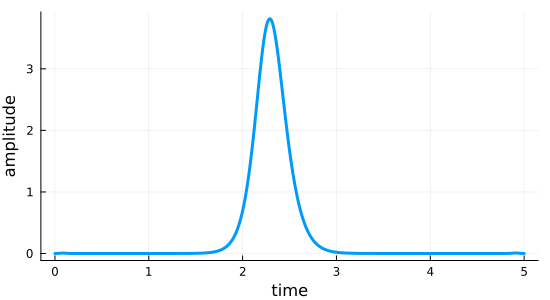

In [17]:
plot_amplitude(
    substitute(a, IdDict(a.control => opt_result_positive.optimized_controls[1])),
    tlist
)

## Tanh-Square-Parametrization for positive amplitude-constrained pulses

In [18]:
a = ParametrizedAmplitude(
    ϵ,
    tlist;
    parametrization=TanhSqParametrization(3),
    parameterize=true
)

problem_tanhsq = ControlProblem(
    objectives=substitute(objectives, IdDict(ϵ => a)),
    lambda_a=10,
    update_shape=(t -> flattop(t, T=5, t_rise=0.3, func=:blackman)),
    tlist=tlist,
    iter_stop=50,
    J_T=QuantumControl.Functionals.J_T_ss,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end
);

In [19]:
opt_result_tanhsq = @optimize_or_load(
    datadir("parametrization#opt_result_tanhsq.jld2"),
    problem_tanhsq;
    method=:krotov
);

In [20]:
opt_result_tanhsq

Krotov Optimization Result
--------------------------
- Started at 2022-10-28T20:42:11.014
- Number of objectives: 1
- Number of iterations: 50
- Value of functional: 6.69321e-02
- Reason for termination: Reached maximum number of iterations
- Ended at 2022-10-28T20:42:11.381 (367 milliseconds)


We can plot the optimized field:

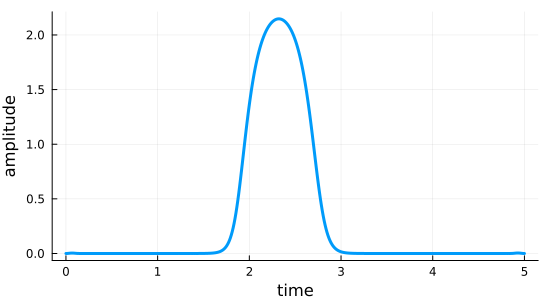

In [21]:
plot_amplitude(
    substitute(a, IdDict(a.control => opt_result_tanhsq.optimized_controls[1])),
    tlist
)

## Logistic-Square-Parametrization for positive amplitude-constrained pulses

In [22]:
a = ParametrizedAmplitude(
    ϵ,
    tlist;
    parametrization=LogisticSqParametrization(3, k=1.0),
    parameterize=true
)

problem_logisticsq = ControlProblem(
    objectives=substitute(objectives, IdDict(ϵ => a)),
    lambda_a=1,
    update_shape=(t -> flattop(t, T=5, t_rise=0.3, func=:blackman)),
    tlist=tlist,
    iter_stop=50,
    J_T=QuantumControl.Functionals.J_T_ss,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end
);

In [23]:
opt_result_logisticsq = @optimize_or_load(
    datadir("parametrization#opt_result_logisticsq.jld2"),
    problem_logisticsq;
    method=:krotov
);

We can plot the optimized field:

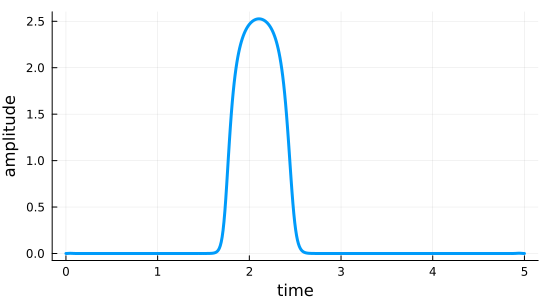

In [24]:
plot_amplitude(
    substitute(a, IdDict(a.control => opt_result_logisticsq.optimized_controls[1])),
    tlist
)

## Tanh-parametrization for amplitude-constrained pulses

In [25]:
a = ParametrizedAmplitude(
    ϵ,
    tlist;
    parametrization=TanhParametrization(-0.5, 0.5),
    parameterize=true
)

problem_tanh = ControlProblem(
    objectives=substitute(objectives, IdDict(ϵ => a)),
    lambda_a=1,
    update_shape=(t -> flattop(t, T=5, t_rise=0.3, func=:blackman)),
    tlist=tlist,
    iter_stop=50,
    J_T=QuantumControl.Functionals.J_T_ss,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end
);

In [26]:
opt_result_tanh = @optimize_or_load(
    datadir("parametrization#opt_result_tanh.jld2"),
    problem_tanh;
    method=:krotov
);

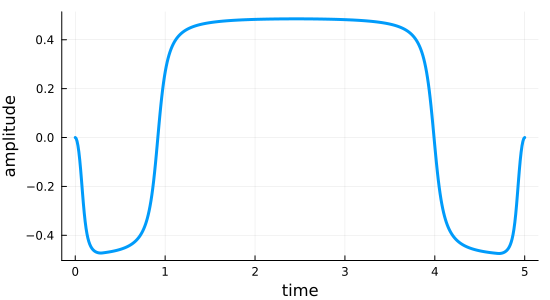

In [27]:
plot_amplitude(
    substitute(a, IdDict(a.control => opt_result_tanh.optimized_controls[1])),
    tlist
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*